In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns   # optional for nicer plots

In [2]:


# --- 1. Load the CSV into a pandas DataFrame ---

df = pd.read_csv("metadata.csv", low_memory=False)

# --- 2. Peek at the data ---
df.head()        # shows the first 5 rows
df.columns       # list of column names

# --- 3. Dimensions (rows, columns) ---
df.shape

# --- 4. Data types and non-null counts ---
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056660 entries, 0 to 1056659
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   cord_uid          1056660 non-null  object 
 1   sha               373766 non-null   object 
 2   source_x          1056660 non-null  object 
 3   title             1056157 non-null  object 
 4   doi               656780 non-null   object 
 5   pmcid             389571 non-null   object 
 6   pubmed_id         498932 non-null   object 
 7   license           1056660 non-null  object 
 8   abstract          821116 non-null   object 
 9   publish_time      1054846 non-null  object 
 10  authors           1032791 non-null  object 
 11  journal           969338 non-null   object 
 12  mag_id            0 non-null        float64
 13  who_covidence_id  482935 non-null   object 
 14  arxiv_id          14249 non-null    object 
 15  pdf_json_files    373766 non-null   object 
 16  

In [4]:
#Basic statistics for numeric columns ---
df.describe()

,mag_id,s2_id
count,0.0,9.764680e+05
mean,NaN,2.175871e+08
std,NaN,5.312281e+07
min,NaN,9.600000e+01
25%,NaN,2.211411e+08
50%,NaN,2.320829e+08
75%,NaN,2.373948e+08
max,NaN,2.491936e+08


In [5]:
# --- 1. Inspect missing data ---
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_percent = (missing_counts / len(df)) * 100
missing_summary = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_%": missing_percent.round(2)
})
missing_summary.head(20)   # top 20 columns by missing values

,missing_count,missing_%
mag_id,1056660,100.00
arxiv_id,1042411,98.65
pmc_json_files,740918,70.12
sha,682894,64.63
pdf_json_files,682894,64.63
pmcid,667089,63.13
who_covidence_id,573725,54.30
pubmed_id,557728,52.78
doi,399880,37.84
url,369726,34.99


In [6]:
'''Columns like mag_id and arxiv_id are >95 % missing. Unless you have a specific need for those IDs, they’re dead weight. Dropping them will simplify memory and analysis'''
drop_cols = ["mag_id","arxiv_id","pmc_json_files","sha",
             "pdf_json_files","pmcid","who_covidence_id","pubmed_id"]
df = df.drop(columns=drop_cols)


In [7]:
'''doi and url are missing in roughly a third of rows.
If you plan to analyse by DOI or pull external resources, you might fill with an empty string or "Unknown". Otherwise you can leave them as NaN.

abstract is missing for about 22 %. That’s too much to fill meaningfully. Usually you just keep the NaN and filter later:'''
# When you need only rows with abstracts:
df_with_abstract = df.dropna(subset=["abstract"])
#journal at ~8 % missing is easy to fill:
df["journal"] = df["journal"].fillna("Unknown")


In [8]:
#Clean key fields
'''publish_time, title, and cord_uid are almost complete'''
df = df.dropna(subset=["title", "publish_time"])  # ensure critical rows are intact


In [9]:
#Date parsing and helper columns
df["publish_time"] = pd.to_datetime(df["publish_time"], errors="coerce")
df["publish_year"] = df["publish_time"].dt.year
#Abstract word count, safe even with NaNs
df["abstract_word_count"] = (
    df["abstract"].fillna("").apply(lambda x: len(x.split()))
)


In [10]:
#save cleaned version
df.to_csv("metadata_cleaned.csv", index=False)


In [13]:
# Count papers by publication year
papers_per_year = df['publish_year'].value_counts().sort_index()

# Top journals
top_journals = (
    df['journal']
      .value_counts()
      .head(10)   # top 10
)

# Most frequent words in titles
all_words = (
    df['title']
      .dropna()
      .str.lower()
      .str.replace(r'[^a-z\s]', '', regex=True)
      .str.split()
)
flat_words = [word for sublist in all_words for word in sublist]
word_freq = Counter(flat_words)
common_words = word_freq.most_common(20)

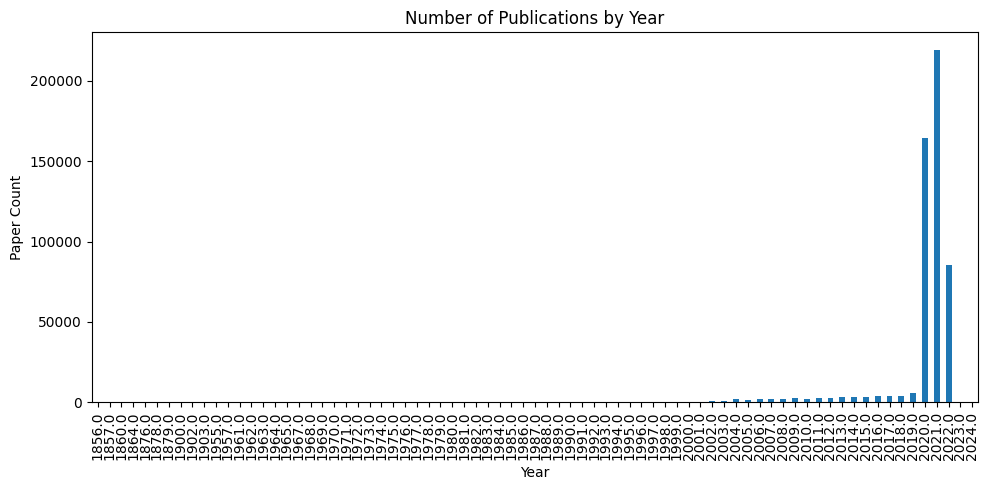

In [14]:
''' Visualizations
Publications Over Time'''


plt.figure(figsize=(10,5))
papers_per_year.plot(kind='bar')
plt.title('Number of Publications by Year')
plt.xlabel('Year')
plt.ylabel('Paper Count')
plt.tight_layout()
plt.show()





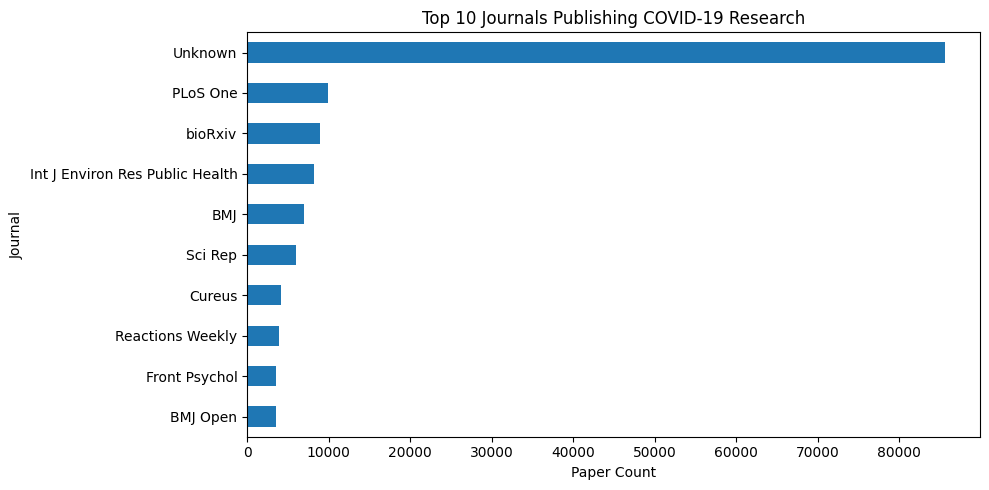

In [15]:
#Top Journals
plt.figure(figsize=(10,5))
top_journals.plot(kind='barh')
plt.title('Top 10 Journals Publishing COVID-19 Research')
plt.xlabel('Paper Count')
plt.ylabel('Journal')
plt.gca().invert_yaxis()   # largest at top
plt.tight_layout()
plt.show()


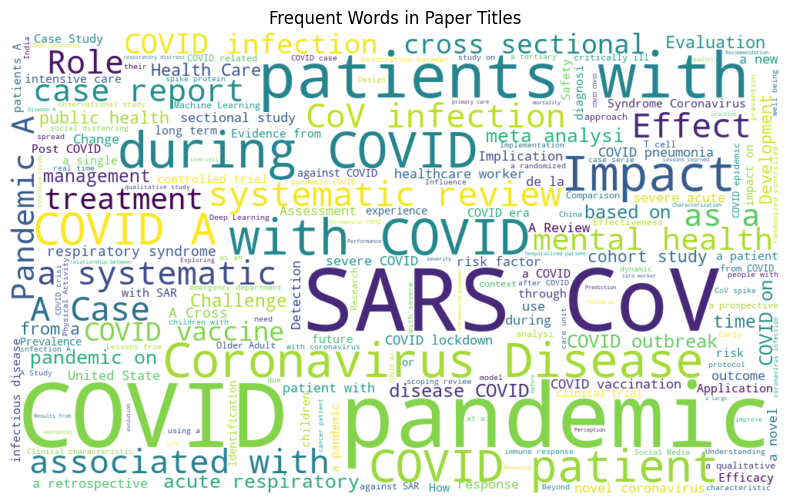

In [16]:
#Word Cloud of Titles
title_text = ' '.join(df['title'].dropna().tolist())
wc = WordCloud(width=1000, height=600,
               background_color='white',
               stopwords={'the','and','of','in','for','to'}) \
               .generate(title_text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Frequent Words in Paper Titles')
plt.show()


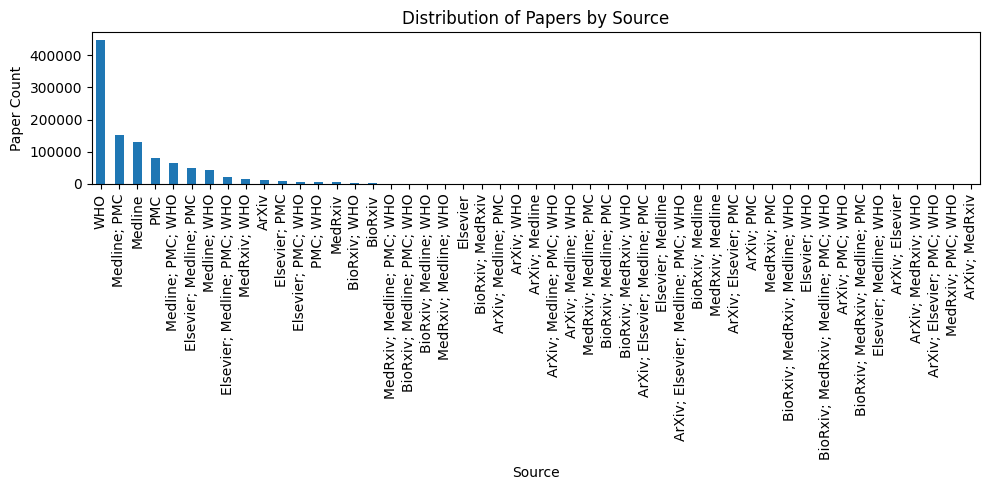

<Figure size 640x480 with 0 Axes>

In [20]:
#Paper Counts by Source
plt.figure(figsize=(10,5))
df['source_x'].value_counts().plot(kind='bar')
plt.title('Distribution of Papers by Source')
plt.xlabel('Source')
plt.ylabel('Paper Count')
plt.tight_layout()
plt.show()
plt.savefig("counts.png", dpi=300)


In [18]:
#quick summary table
summary = pd.DataFrame({
    "Total Papers": [len(df)],
    "Years Covered": [f"{df['publish_year'].min()}–{df['publish_year'].max()}"],
    "Unique Journals": [df['journal'].nunique()],
})
summary


,Total Papers,Years Covered,Unique Journals
0,1054343,1856.0–2024.0,54973


In [19]:
#save the plots
plt.savefig("filename.png", dpi=300)

<Figure size 640x480 with 0 Axes>

In [21]:
# sample fer stremlit app
df.sample(50000, random_state=42).to_csv("cleaned_metadata_sample.csv", index=False)
